# Analysis of gold price development in an economic crash
![gold_image](images/gold_coins_bars.jpg)


The inspiration for this analysis is this <a href='https://www.reddit.com/r/dataisbeautiful/comments/fjvtt5/oc_current_market_sell_off_compared_to_major_ones/'> reddit post</a>, where the current crash is compared to major ones in the past.

<b>Gold is generally known as the safe haven for investors in such crises and is therefore the profiteer of uncertain times. But is this really the case?</b>


### Content
- [Data](#data)
- [Get the gold price](#gold)
- [Get the S&P 500 data](#sp)
- [Identify the relevant dates](#dates)
    - [Check dates](#checkdated)
    - [Calculate the length of the crises](#length)
    - [First conclusion](#first)
- [Create a DataFrame for each crisis](#createdf)
- [Join DataFrames](#join)
- [Visualizations](#chart)
- [Max percentage gain](#max)
- [Final conclusion](#final)


<a id='data'></a>
### Data

The gold price data is from Quandl.  <a herf="https://www.quandl.com">Quandl</a> is a data provider, which offers access to all sorts of quantitative data. I used it because I can query the gold price in USD from 1968 till now for free.

To identify dates for the crashes in the Reddit post, I used <a href='https://en.wikipedia.org/wiki/List_of_economic_crise'>wikipedia</a> and data from the S&P500, since gold is mostly traded in USD and the S&P 500 is one of the most commonly followed equity indices, and many consider it to be one of the best representations of the U.S. stock market. The range of dates is from the high before the crash to the date where the price is higher than the high before the crisis.
    
<b>Start and end dates for major crashes in the scope of our time frame (from 1968):</b>
- 1970s energy crisis: 11.05.1969 - 10.05.1970
- 1973 oil crisis: 02.01.1973 - 29.09.1974
- Early 1980s recession: 24.11.1980 - 02.08.1982
- Black Monday: 17.08.1987 - 30.11.1987
- Dot-com bubble: 20.03.2000 - 30.09.2002
- Financial crisis of 2007: 09.10.2007 - 02.03.2009
- Corona (2020): 19.02.2020 - 18.08.2020

<b>It is important to note how the start and end date where selected:</b>
- <u>start date</u>: date with the highest value before the drop
- <u>end date</u>: date when the S&P 500 rises above the highest local high before the crisis
- this could be a <b>limitation</b>, e.g. corona is very much going on, one year after and it could be that when a crisis takes a certain time period that the gold price will respond differently but this is up to another analysis.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import quandl
import time
from datetime import datetime
from yahoofinancials import YahooFinancials
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# import API-Key 
import constants
# ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# ignore SettingWithCopyWarning:
pd.options.mode.chained_assignment = None

# set seaborn style for coherence
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

<a id='gold'></a>
## Get the gold price
- use Quandle to query the historical gold price

In [9]:
# importet the api key from another python file which is in .gitignore so my key stays private
quandl.ApiConfig.api_key = constants.API_KEY_QUANDL

# get the Data from quadl
# we only need the second column (USD(PM))
gold_data = quandl.get('LBMA/GOLD.2')

# save dataframe to csv, to have a local copy, since we don't want to make an api request everytime we rerun this script 
gold_data.to_csv('data/gold_data.csv')

In [4]:
gold_data = pd.read_csv('data/gold_data.csv')
gold_data['Date'] = pd.to_datetime(gold_data['Date'])
gold_data = gold_data.set_index('Date')

# first and last day of the query
gold_data.iloc[[0, -1]]

,USD (PM)
Date,
1968-04-01,37.7
2021-04-09,1741.2


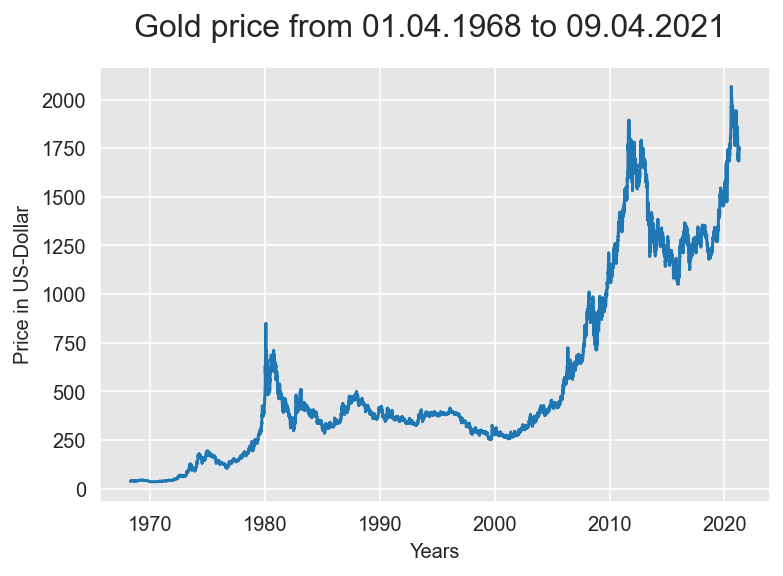

In [6]:
# check data
plt.plot(gold_data)
plt.title('Gold price from 01.04.1968 to 09.04.2021 ', fontsize=16, pad=15)
plt.xlabel('Years')
plt.ylabel('Price in US-Dollar');

<a id='sp'></a>
## Get S&P 500 price
- use YahooFinancials to query the historical S&P 500 price

In [20]:
# initiate yahoo financial with the ticker symbol
ticker = '^GSPC'
yahoo_financials = YahooFinancials(ticker)

# define the date range 
# this will return a dict so we filter it to get the data related to the prices
sp500 = yahoo_financials.get_historical_price_data(start_date='1968-04-01', end_date='2021-04-10', time_interval='daily')['^GSPC']['prices']

In [21]:
# first enty in the dict 
sp500[0]

{'date': -55243800,
 'high': 93.55000305175781,
 'low': 91.11000061035156,
 'open': 0.0,
 'close': 92.4800033569336,
 'volume': 17730000,
 'adjclose': 92.4800033569336,
 'formatted_date': '1968-04-01'}

In [22]:
# for loop to get the desied data (data and price) in a list form
dates = []
adj_close = []

for x in range(len(sp500)):
    date = sp500[x]['formatted_date']
    value = sp500[x]['adjclose']
    
    dates.append(date)
    adj_close.append(value)

# dict from the lists to easily create a DataFrame
d = {'date' : dates, 'value' : adj_close}
sp_500 = pd.DataFrame(d)

# set date to DateTime and as an index
sp_500['date'] = pd.to_datetime(sp_500['date'])
sp_500 = sp_500.set_index('date')

# save to csv
sp_500.to_csv('data/sp_500.csv')

In [5]:
sp_500 = pd.read_csv('data/sp_500.csv')
sp_500['Date'] = pd.to_datetime(sp_500['date'])
sp_500.drop(['date'], axis=1, inplace=True)
sp_500 = sp_500.set_index('Date')

In [126]:
sp_500.iloc[[0,-1]]

,value
Date,
1968-04-01,92.480003
2021-04-09,4128.799805


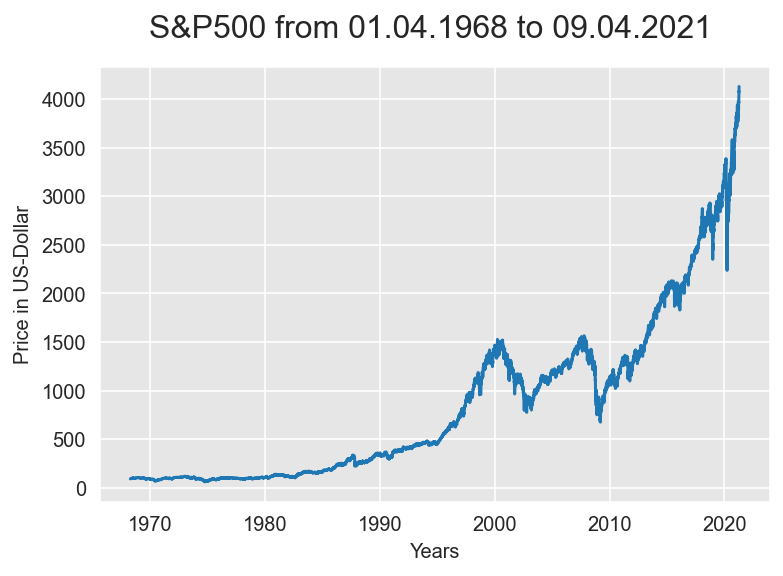

In [127]:
# check data
plt.plot(sp_500);
plt.title('S&P500 from 01.04.1968 to 09.04.2021 ', fontsize=16, pad=15)
plt.xlabel('Years')
plt.ylabel('Price in US-Dollar');

<a id='dates'></a>
## Identify relevant dates
- start date of the crisis which is already researched
- lowest local low after the start 
- date where the price was higher than the price of the start date

In [128]:

## Read in the data
# sp_500 = pd.read_csv('data/sp_500.csv')
# sp_500['date'] = pd.to_datetime(sp_500['date'])
# sp_500 = sp_500.set_index('date')

In [6]:
# function to find dates 
def find_date(df, start_date):
    '''
    function which returns the start date, finds the date with the next higher price and than the date with the
    lowest price in that timeframe.
    
    Input
        df: pandas DataFrame with the timeseries data, expects date as index with a column called value
        with the prices.
        start_date: start date of the crisis (yyyy-mm-dd).
    
    Returns
        tuple, wich includes:
            start_date
            end_date: date where the price is higher than the starting price
            min_date: date with the min price 
            df_range: pandas DataFrame with the prices 
    '''
    
    # make a new df with the strarting date to make the code simpler
    df_start = df.loc[start_date:]
    # transfom colum to uderlying nunpy array to find the fist value that is higher than the starting value
    df_list = df_start['value'].to_numpy()
    idx = np.argmax(df_list > df_list[0])
    # use the index of the higher price to find the date
    end_date = df_start.iloc[idx]
    end_date = end_date.name.strftime('%Y-%m-%d')
    
    # find global min price from start to end date
    # create full Dataframe
    df_range = df.loc[start_date:end_date]
    # find min price
    min_date = df_range[['value']].idxmin().value.strftime('%Y-%m-%d')
    
    #save the data in one tuple 
    data = start_date, end_date, min_date, df_range
    
    return data

### Use function to find the relevant dates

In [7]:
# list with the starting dates 
staring_dates = ['11.05.1969', '02.01.1973', '24.11.1980', '17.08.1987', '20.03.2000', '09.10.2007', '10.02.2020']
list_name = ['energy_crisis_1970', 'oil_crisis_1973', 'early_1980s_recession', 'black_monday', 'dot_com_bubble', 
             'financial_crisis_2007', 'corona_2020']

In [8]:
dates_1970_energy = find_date(sp_500, '1968-11-29')
dates_1973_oil = find_date(sp_500, '1973-01-11')
dates_1980_recession = find_date(sp_500, '1980-11-28')
dates_Black_Monday = find_date(sp_500, '1987-08-25')
dates_Dotcombubble = find_date(sp_500, '2000-03-24')
dates_Financial_crisis = find_date(sp_500, '2007-10-09')
dates_Corona = find_date(sp_500, '2020-02-19')

# list with dfs
list_df_dates = [dates_1970_energy, dates_1973_oil, dates_1980_recession, dates_Black_Monday, dates_Dotcombubble, 
              dates_Financial_crisis, dates_Corona]

<a id='checkdates'></a>
#### Check dates

In [9]:
for crisis, name in zip(list_df_dates,list_name):
    print(f'{name} start:{crisis[0]}, low:{crisis[2]}, high:{crisis[1]}')

energy_crisis_1970 start:1968-11-29, low:1970-05-26, high:1972-03-06
oil_crisis_1973 start:1973-01-11, low:1974-10-03, high:1980-07-17
early_1980s_recession start:1980-11-28, low:1982-08-12, high:1982-11-03
black_monday start:1987-08-25, low:1987-12-04, high:1989-07-26
dot_com_bubble start:2000-03-24, low:2002-10-09, high:2007-05-30
financial_crisis_2007 start:2007-10-09, low:2009-03-09, high:2013-03-28
corona_2020 start:2020-02-19, low:2020-03-23, high:2020-08-18


<a id='length'></a>
#### Length of the crises

lets check how many days a crisis usually lasts and the time range from high to low and high again. 

In [10]:
def get_range(data):
    '''
    Input
        data: Tuple with start date, end date, min price date and DataFrame
    '''
    # defina date format
    date_format = '%Y-%m-%d'
    #create dates
    start = datetime.strptime(data[0], date_format)
    end = datetime.strptime(data[1], date_format)
    low_date = datetime.strptime(data[2], date_format)
    
    #calculate deltas
    days_high_low = low_date - start
    days_low_high = end - low_date
    days_full = end - start
    
    return days_high_low.days, days_low_high.days, days_full.days

In [11]:
days_1970_energy = get_range(dates_1970_energy)
days_1973_oil = get_range(dates_1973_oil)
days_1980_recession = get_range(dates_1980_recession)
days_Black_Monday = get_range(dates_Black_Monday)
days_Dotcombubble = get_range(dates_Dotcombubble)
days_Financial_crisis = get_range(dates_Financial_crisis)
days_Corona = get_range(dates_Corona)

In [12]:
days_in_crisis = {'energy_crisis_1970': {'days_full': days_1970_energy[2], 'days_high_low': days_1970_energy[0], 'days_low_high': days_1970_energy[1]},
                  'oil_crisis_1973': {'days_full': days_1973_oil[2], 'days_high_low': days_1973_oil[0], 'days_low_high': days_1973_oil[1]},
                  'early_1980s_recession': {'days_full': days_1980_recession[2], 'days_high_low': days_1980_recession[0], 'days_low_high': days_1980_recession[1]},
                  'black_monday': {'days_full': days_Black_Monday[2], 'days_high_low': days_Black_Monday[0], 'days_low_high': days_Black_Monday[1]},
                  'dot_com_bubble': {'days_full': days_Dotcombubble[2], 'days_high_low': days_Dotcombubble[0], 'days_low_high': days_Dotcombubble[1]},
                  'financial_crisis_2007': {'days_full': days_Financial_crisis[2], 'days_high_low': days_Financial_crisis[0], 'days_low_high': days_Financial_crisis[1]},
                  'corona_2020': {'days_full': days_Corona[2], 'days_high_low': days_Corona[0], 'days_low_high': days_Corona[1]}
                 }

In [13]:
df_days_in_crisis = pd.DataFrame.from_dict(days_in_crisis, orient='index')
df_days_in_crisis.describe()

,days_full,days_high_low,days_low_high
count,7.000000,7.000000,7.00000
mean,1449.142857,482.142857,967.00000
std,1011.764536,314.383221,795.26746
min,181.000000,33.000000,83.00000
25%,703.000000,309.000000,374.00000
50%,1193.000000,543.000000,650.00000
75%,2310.000000,626.000000,1587.00000
max,2744.000000,929.000000,2114.00000


In [14]:
# based on the distibution I will have to look at the median 
df_days_in_crisis[['days_full', 'days_high_low', 'days_low_high']].median()

days_full        1193.0
days_high_low     543.0
days_low_high     650.0
dtype: float64

### Inspect days to new high

In [16]:
df_days_in_crisis.sort_values('days_full', ascending=False)

,days_full,days_high_low,days_low_high
oil_crisis_1973,2744,630,2114
dot_com_bubble,2623,929,1694
financial_crisis_2007,1997,517,1480
energy_crisis_1970,1193,543,650
early_1980s_recession,705,622,83
black_monday,701,101,600
corona_2020,181,33,148


<a id='first'></a>
## Conclusion days in crisis
- the average number of days (median) between the <b>high before a crisis and a new high</b> is 1193 days (min:181 / max:2744)
- the average number of days (median) between the <b>high before the crisis and the global low during the crisis</b> is 543 days (min:33 / max:929)
- the average number of days (median) between the <b>low during the crisis and the new high</b> is 650 days (min:83 / max: 2114)
- The Corona crash is the shorted crash in history. It only took the S&P 500 181 days to reach a new high. This is quite short compared to the oil-crisis in 1973, where it took 2744 days to reach a new high


<a id='createdf'></a>
## Create DataFrames for each crisis
1. Filter the main DF with the dates 
2. Calculate cumulative ptc change 

In [17]:
dates_list = [dates_1970_energy, dates_1973_oil, dates_1980_recession, dates_Black_Monday, dates_Dotcombubble, dates_Financial_crisis, dates_Corona]
dates_name_list = ['dates_1970_energy', 'dates_1973_oil', 'dates_1980_recession', 'dates_Black_Monday', 'dates_Dotcombubble', 'dates_Financial_crisis', 
                  'dates_Corona']

for date, date_name in zip(dates_list, dates_name_list):
    print(f'{date_name}= stat date:{date[0]}, end date:{date[1]} and date with the lowest price:{date[2]}')

dates_1970_energy= stat date:1968-11-29, end date:1972-03-06 and date with the lowest price:1970-05-26
dates_1973_oil= stat date:1973-01-11, end date:1980-07-17 and date with the lowest price:1974-10-03
dates_1980_recession= stat date:1980-11-28, end date:1982-11-03 and date with the lowest price:1982-08-12
dates_Black_Monday= stat date:1987-08-25, end date:1989-07-26 and date with the lowest price:1987-12-04
dates_Dotcombubble= stat date:2000-03-24, end date:2007-05-30 and date with the lowest price:2002-10-09
dates_Financial_crisis= stat date:2007-10-09, end date:2013-03-28 and date with the lowest price:2009-03-09
dates_Corona= stat date:2020-02-19, end date:2020-08-18 and date with the lowest price:2020-03-23


### Filter the main DataFrames with the dates

In [18]:
# 1970s energy crisis
energy_crisis_1970 = gold_data.loc[dates_1970_energy[0]:dates_1970_energy[1]]
sp_energy_crisis_1970 = sp_500.loc[dates_1970_energy[0]:dates_1970_energy[1]]

# 1973 oil crisis
oil_crisis_1973 = gold_data.loc[dates_1973_oil[0]:dates_1973_oil[1]]
sp_oil_crisis_1973 = sp_500.loc[dates_1973_oil[0]:dates_1973_oil[1]]

# Early 1980s recession:
early_1980s_recession = gold_data.loc[dates_1980_recession[0]:dates_1980_recession[1]]
sp_early_1980s_recession = sp_500.loc[dates_1980_recession[0]:dates_1980_recession[1]]

# Black Monday:
black_monday = gold_data.loc[dates_Black_Monday[0]:dates_Black_Monday[1]]
sp_black_monday = sp_500.loc[dates_Black_Monday[0]:dates_Black_Monday[1]]

# Dot-com bubble:
dot_com_bubble = gold_data.loc[dates_Dotcombubble[0]:dates_Dotcombubble[1]]
sp_dot_com_bubble = sp_500.loc[dates_Dotcombubble[0]:dates_Dotcombubble[1]]

# Financial crisis of 2007–08:
financial_crisis_2007 = gold_data.loc[dates_Financial_crisis[0]:dates_Financial_crisis[1]]
sp_financial_crisis_2007 = sp_500.loc[dates_Financial_crisis[0]:dates_Financial_crisis[1]]

# Corona (2020): 10.02.2020 - till now (29.07.2020)
corona_2020 = gold_data.loc[dates_Corona[0]:dates_Corona[1]]
sp_corona_2020 = sp_500.loc[dates_Corona[0]:dates_Corona[1]]

### Calculate cumulated ptc change for each crisis

In [19]:
energy_crisis_1970['sum_ptc_change_g'] = energy_crisis_1970['USD (PM)'].pct_change().cumsum()
sp_energy_crisis_1970['sum_ptc_change_sp'] = sp_energy_crisis_1970['value'].pct_change().cumsum()

oil_crisis_1973['sum_ptc_change_g'] = oil_crisis_1973['USD (PM)'].pct_change().cumsum()
sp_oil_crisis_1973['sum_ptc_change_sp'] = sp_oil_crisis_1973['value'].pct_change().cumsum()

early_1980s_recession['sum_ptc_change_g'] = early_1980s_recession['USD (PM)'].pct_change().cumsum()
sp_early_1980s_recession['sum_ptc_change_sp'] = sp_early_1980s_recession['value'].pct_change().cumsum()

black_monday['sum_ptc_change_g'] = black_monday['USD (PM)'].pct_change().cumsum()
sp_black_monday['sum_ptc_change_sp'] = sp_black_monday['value'].pct_change().cumsum()

dot_com_bubble['sum_ptc_change_g'] = dot_com_bubble['USD (PM)'].pct_change().cumsum()
sp_dot_com_bubble['sum_ptc_change_sp'] = sp_dot_com_bubble['value'].pct_change().cumsum()

financial_crisis_2007['sum_ptc_change_g'] = financial_crisis_2007['USD (PM)'].pct_change().cumsum()
sp_financial_crisis_2007['sum_ptc_change_sp'] = sp_financial_crisis_2007['value'].pct_change().cumsum()

corona_2020['sum_ptc_change_g'] = corona_2020['USD (PM)'].pct_change().cumsum()
sp_corona_2020['sum_ptc_change_sp'] = sp_corona_2020['value'].pct_change().cumsum()

<a id='join'></a>
### Join Gold and S&P 500 DataFrames
We need to make an inner join because the dates in the timeframe aren't equal and therefore days befor and during the crisis wouldn't add up in the visualization.

In [20]:
# join DataFrames with Gold and S&P 500 values on the Datetimeindex
energy_crisis_1970 = pd.merge(energy_crisis_1970, sp_energy_crisis_1970, left_index=True, right_index=True)
oil_crisis_1973 = pd.merge(oil_crisis_1973, sp_oil_crisis_1973, left_index=True, right_index=True)
early_1980s_recession = pd.merge(early_1980s_recession, sp_early_1980s_recession, left_index=True, right_index=True)
black_monday = pd.merge(black_monday, sp_black_monday, left_index=True, right_index=True)
dot_com_bubble = pd.merge(dot_com_bubble, sp_dot_com_bubble, left_index=True, right_index=True)
financial_crisis_2007 = pd.merge(financial_crisis_2007, sp_financial_crisis_2007, left_index=True, right_index=True)
corona_2020 = pd.merge(corona_2020, sp_corona_2020, left_index=True, right_index=True)

In [21]:
# create days from top
energy_crisis_1970['days_in_crisis'] = np.arange(0,len(energy_crisis_1970), 1)
oil_crisis_1973['days_in_crisis'] = np.arange(0,len(oil_crisis_1973), 1)
early_1980s_recession['days_in_crisis'] = np.arange(0,len(early_1980s_recession), 1)
black_monday['days_in_crisis'] = np.arange(0,len(black_monday), 1)
dot_com_bubble['days_in_crisis'] = np.arange(0,len(dot_com_bubble), 1)
financial_crisis_2007['days_in_crisis'] = np.arange(0,len(financial_crisis_2007), 1)
corona_2020['days_in_crisis'] = np.arange(0,len(corona_2020), 1)

In [22]:
# create function to get the gold prices before the crisis
def p_crisis(df_gold, df_sp, from_date, d):
    '''
    df_gold = DataFrame with Gold prices
    df_sp = DataFrame with S&P prices
    from_date = Date from which we start counting back
    d = how many days
    '''
    
    # claculate the start day for a period of x days
    end = datetime.strptime(from_date, '%Y-%m-%d')
    start = end - pd.offsets.Day(d)
    # inspired by https://stackoverflow.com/questions/40192704/filter-pandas-dataframe-for-past-x-days
    
    # create the DataFrame with the dates
    df_gold = df_gold.loc[start:from_date]
    df_sp = df_sp.loc[start:from_date]
    
    # sort the index to calculate cumulative sum
    df_gold.sort_index(ascending = False, inplace = True)
    df_gold['sum_ptc_change_g'] = df_gold['USD (PM)'].pct_change().cumsum()
    
    df_sp.sort_index(ascending = False, inplace = True)
    df_sp['sum_ptc_change_sp'] = df_sp['value'].pct_change().cumsum()
    
    # join DataFrames on DateTimeIndex
    df = pd.merge(df_gold, df_sp, left_index=True, right_index=True)
    
    # create days in crisis
    df['days_in_crisis'] = np.arange(0,-len(df), -1)
    
    # redo sort index 
    df.sort_index(ascending = True, inplace = True)
    
    # exclude the last row because it would be dublicated by appending the DataFrames
    df = df.iloc[:-1]
    
    return df

In [23]:
# create the DataFrame with 
p_1970 = p_crisis(gold_data, sp_500, dates_1970_energy[0], 100)
p_1973 = p_crisis(gold_data, sp_500, dates_1973_oil[0], 100)
p_1980 = p_crisis(gold_data, sp_500, dates_1980_recession[0], 100)
p_1987 = p_crisis(gold_data, sp_500, dates_Black_Monday[0], 100)
p_2000 = p_crisis(gold_data, sp_500, dates_Dotcombubble[0], 100)
p_2007 = p_crisis(gold_data, sp_500, dates_Financial_crisis[0], 100)
p_2020 = p_crisis(gold_data, sp_500, dates_Corona[0], 100)

In [24]:
# function to append DataFrames
def append_DataFrame(p_df, c_df):
    '''
    p_df = DataFrame containing the prices prio crisis 
    c_df = DataFrame containign the prices in the crisis    
    '''
    df = p_df.append(c_df)
    return df

In [25]:
# create the finale DataFrame with the data before and during the crisis
energy_crisis_1970 = append_DataFrame(p_1970, energy_crisis_1970)
oil_crisis_1973 = append_DataFrame(p_1973, oil_crisis_1973)
early_1980s_recession = append_DataFrame(p_1980, early_1980s_recession)
black_monday = append_DataFrame(p_1987, black_monday)
dot_com_bubble = append_DataFrame(p_2000, dot_com_bubble)
financial_crisis_2007 = append_DataFrame(p_2007, financial_crisis_2007)
corona_2020 = append_DataFrame(p_2020, corona_2020)

<a id='chart'></a>
## Visualizations

Text(0, 0.5, 'change in percent')

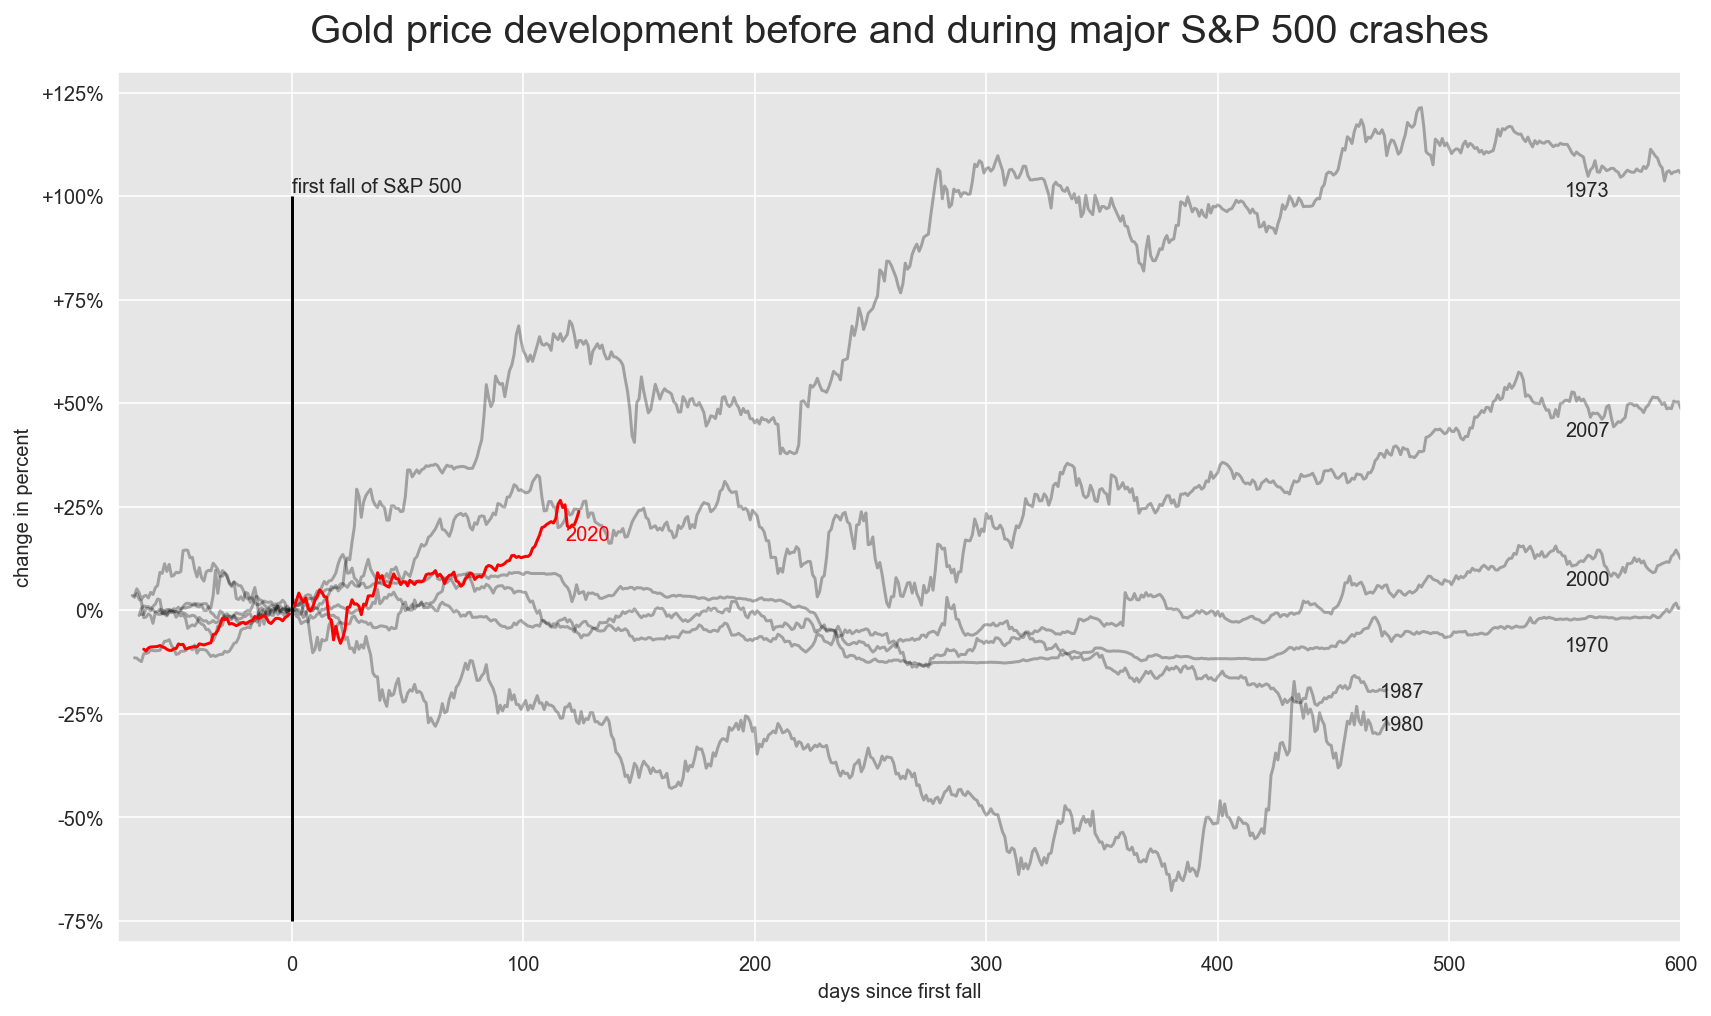

In [58]:
ticks = np.arange(-0.75, 1.50, 0.25)
tick_names = ['-75%', '-50%', '-25%', '0%', '+25%', '+50%', '+75%', '+100%', '+125%']

plt.subplots(figsize=(14,8))

plt.plot(energy_crisis_1970['days_in_crisis'], energy_crisis_1970['sum_ptc_change_g'], label='1970', color='k', alpha=0.3)
plt.plot(oil_crisis_1973['days_in_crisis'], oil_crisis_1973['sum_ptc_change_g'], label='1973', color='k', alpha=0.3)
plt.plot(early_1980s_recession['days_in_crisis'], early_1980s_recession['sum_ptc_change_g'], label='1980', color='k', alpha=0.3)
plt.plot(black_monday['days_in_crisis'], black_monday['sum_ptc_change_g'], label='1987', color='k', alpha=0.3)
plt.plot(dot_com_bubble['days_in_crisis'], dot_com_bubble['sum_ptc_change_g'], label='2000', color='k', alpha=0.3)
plt.plot(financial_crisis_2007['days_in_crisis'], financial_crisis_2007['sum_ptc_change_g'], label='2007', color='k', alpha=0.3)
plt.plot(corona_2020['days_in_crisis'], corona_2020['sum_ptc_change_g'], label='2020', color='r')

plt.annotate('1970', xy=(550, -0.1))
plt.annotate('1973', xy=(550, 1))
plt.annotate('1980', xy=(470, -0.29))
plt.annotate('1987', xy=(470, -0.21))
plt.annotate('2000', xy=(550, 0.06))
plt.annotate('2007', xy=(550, 0.42))
plt.annotate('2020', xy=(118, 0.17), color='r')

plt.vlines(0, colors='k', ymin=-0.75, ymax=1)
plt.annotate('first fall of S&P 500', xy=(0, 1.01))

plt.xlim(-75,600)
plt.ylim(-0.80, 1.30)
plt.yticks(ticks, tick_names)
plt.title('Gold price development before and during major S&P 500 crashes', fontsize=20, pad=15)
plt.xlabel('days since first fall')
plt.ylabel('change in percent')
# plt.savefig('images/Gold_price_development_during_crashes.png', dpi=300);

#### Define function for one on one visualizatio

In [59]:
def one_on_one_plot(df, crisis_name):
    '''
    df= DataFrame for crisis
    crisis_name = name of the crisis
    '''
    
    plt.subplots(figsize=(12,6))
    
    plt.plot(df['days_in_crisis'], df['sum_ptc_change_g'], label = 'Gold', color = 'y')
    plt.plot(df['days_in_crisis'], df['sum_ptc_change_sp'], label = 'S&P 500', color = 'k', alpha = 0.3) 

    plt.vlines(0, colors='k', ymin=-0.75, ymax=1)
    plt.annotate('first fall of S&P 500', xy=(0, 1.01))

    plt.xlim(-75,len(df))
    plt.yticks(ticks, tick_names)
    plt.title(f'{crisis_name}: Gold and S&P 500 price development', fontsize=20, pad=15)
    plt.xlabel('days before and after the first fall of the S&P 500')
    plt.ylabel('change in percent')
    plt.legend();

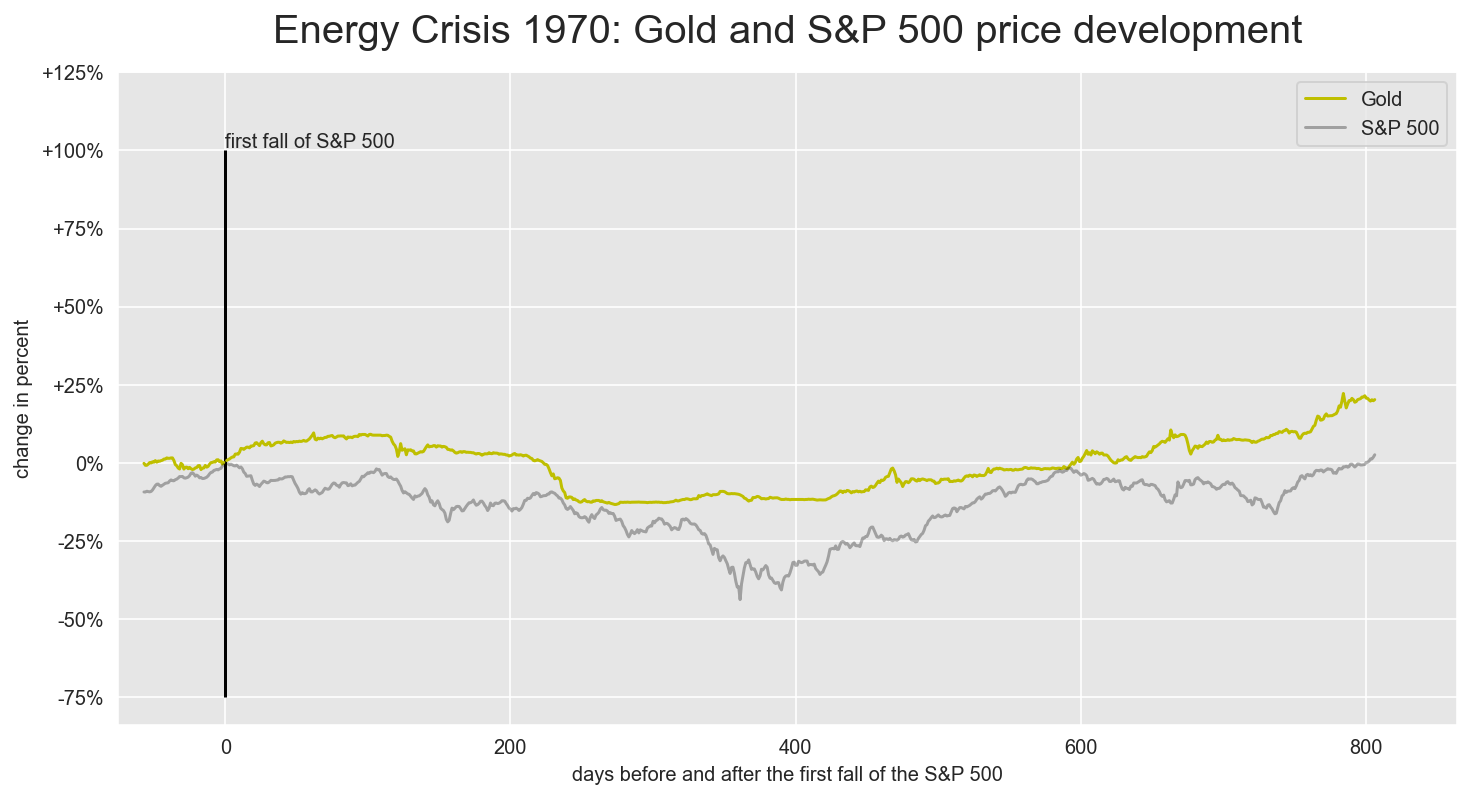

In [60]:
one_on_one_plot(energy_crisis_1970, 'Energy Crisis 1970')

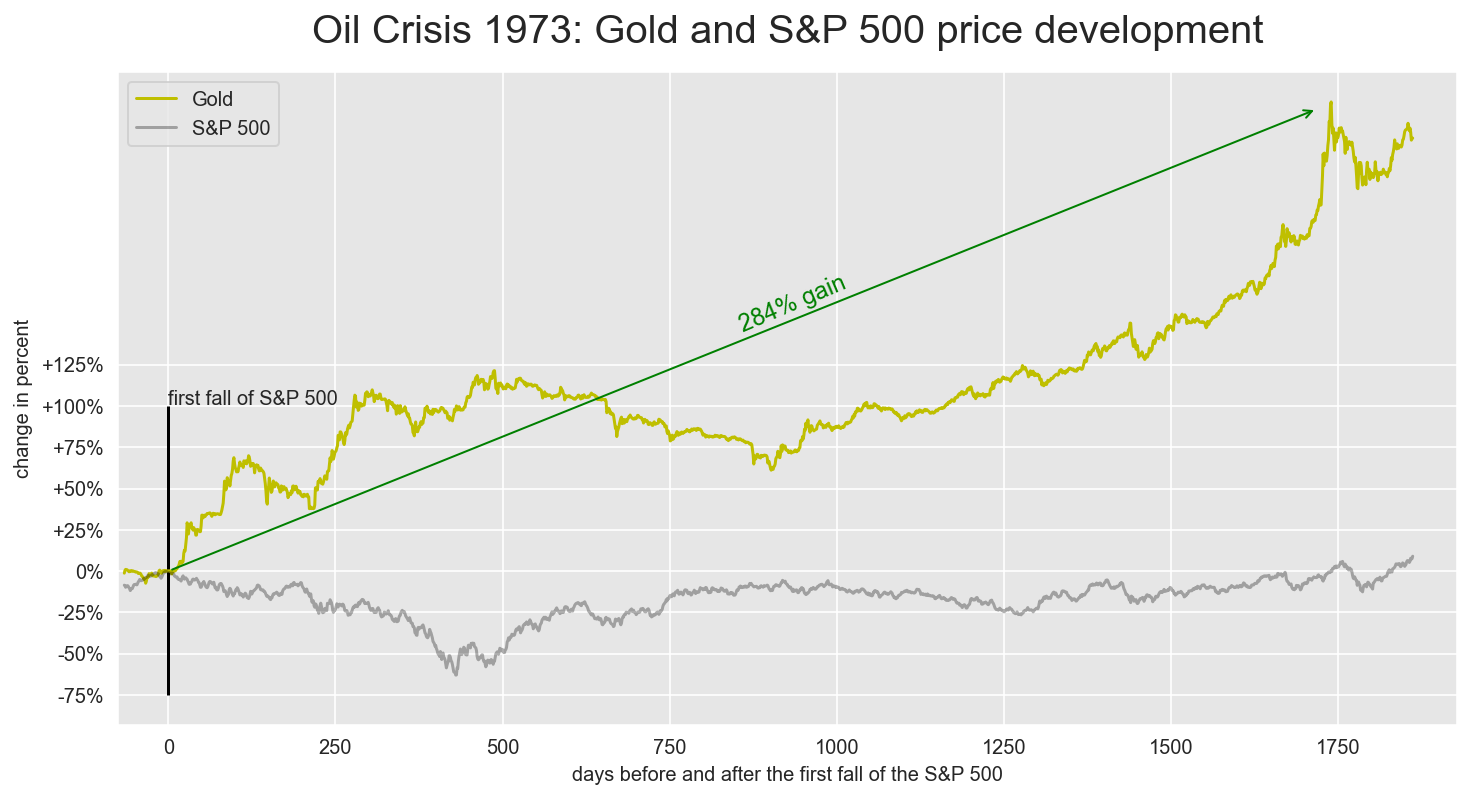

In [61]:
one_on_one_plot(oil_crisis_1973, 'Oil Crisis 1973')
plt.annotate('', xy=(1720, 2.8), xytext=(0,0), arrowprops={'arrowstyle': '->', 'color':'green'}, va='center')
plt.annotate('284% gain', xy=(850, 1.45), color='green', rotation=23, fontsize=12);


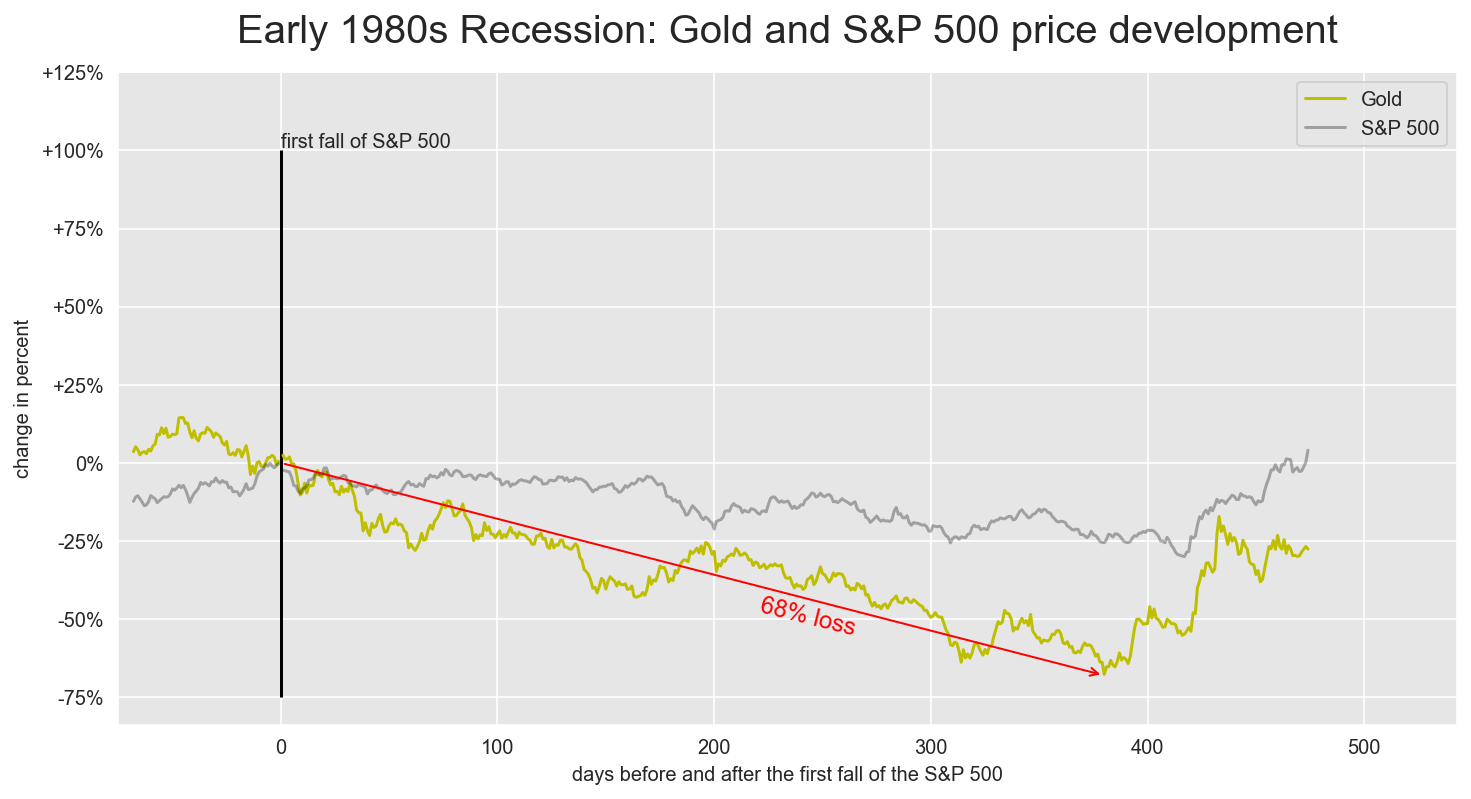

In [62]:
one_on_one_plot(early_1980s_recession, 'Early 1980s Recession')
plt.annotate('', xy=(380, -0.68), xytext=(0,0), arrowprops={'arrowstyle': '->', 'color':'red'}, va='center')
plt.annotate('68% loss', xy=(220, -0.55), color='red', rotation=-14, fontsize=12);

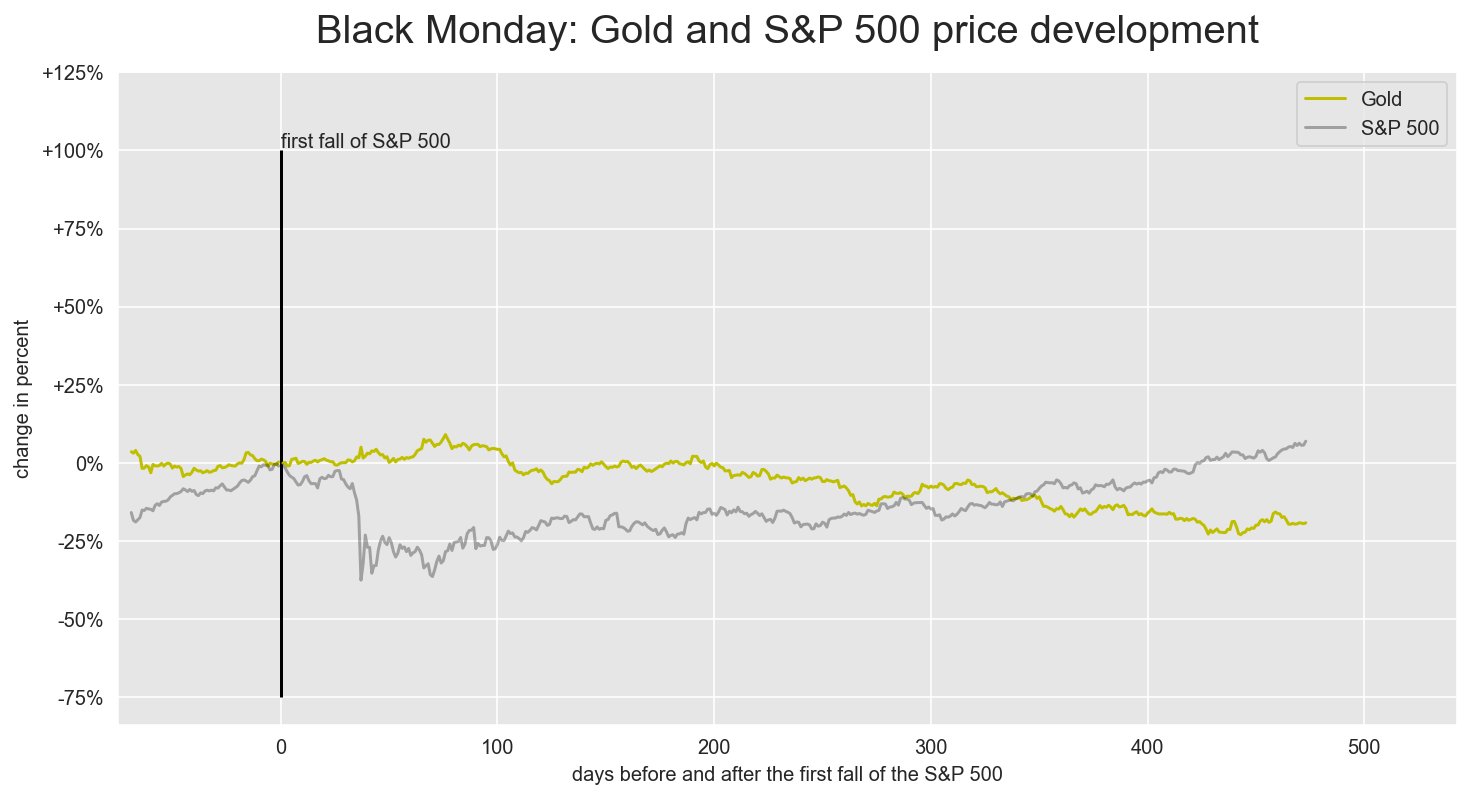

In [63]:
one_on_one_plot(black_monday, 'Black Monday')

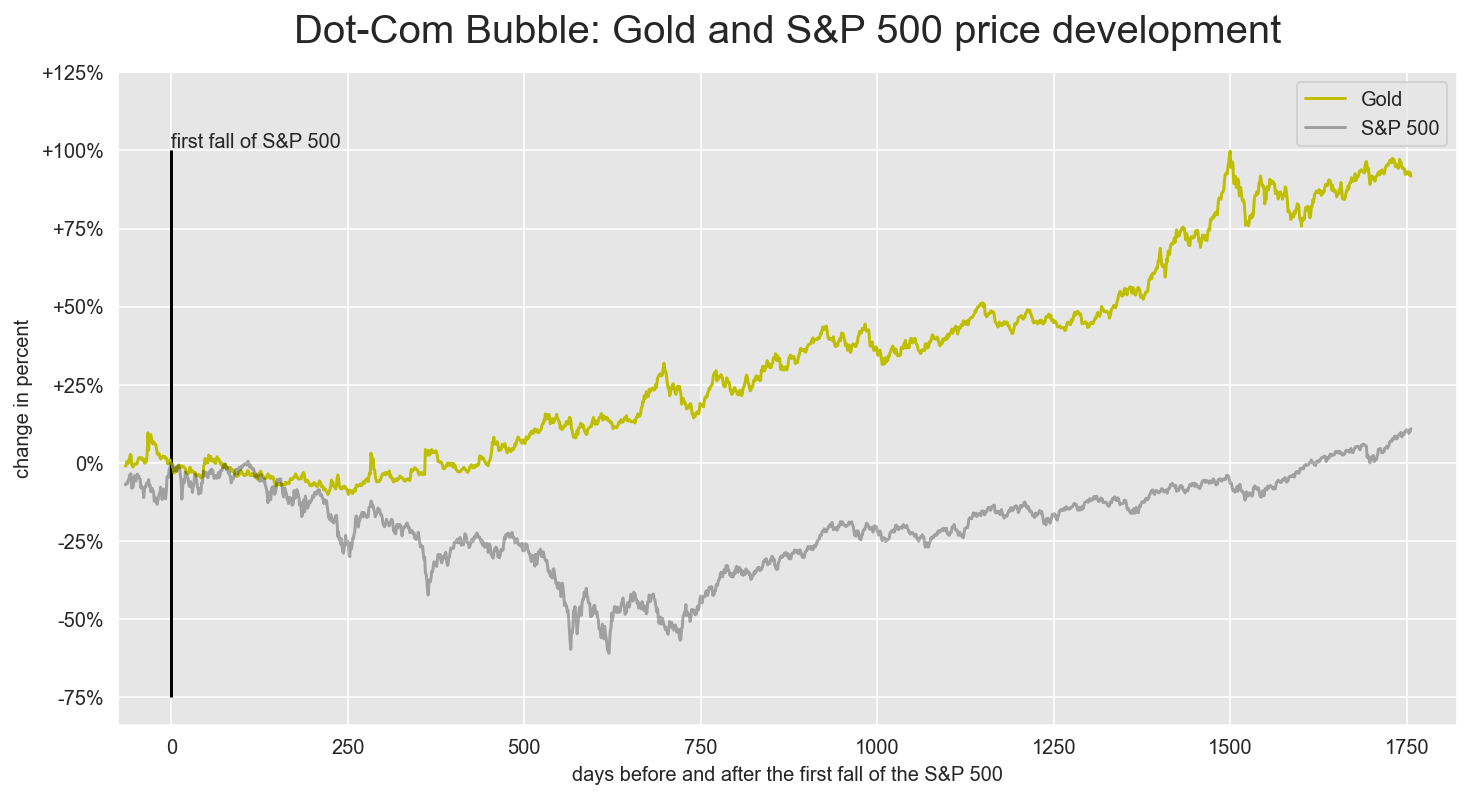

In [64]:
one_on_one_plot(dot_com_bubble, 'Dot-Com Bubble')

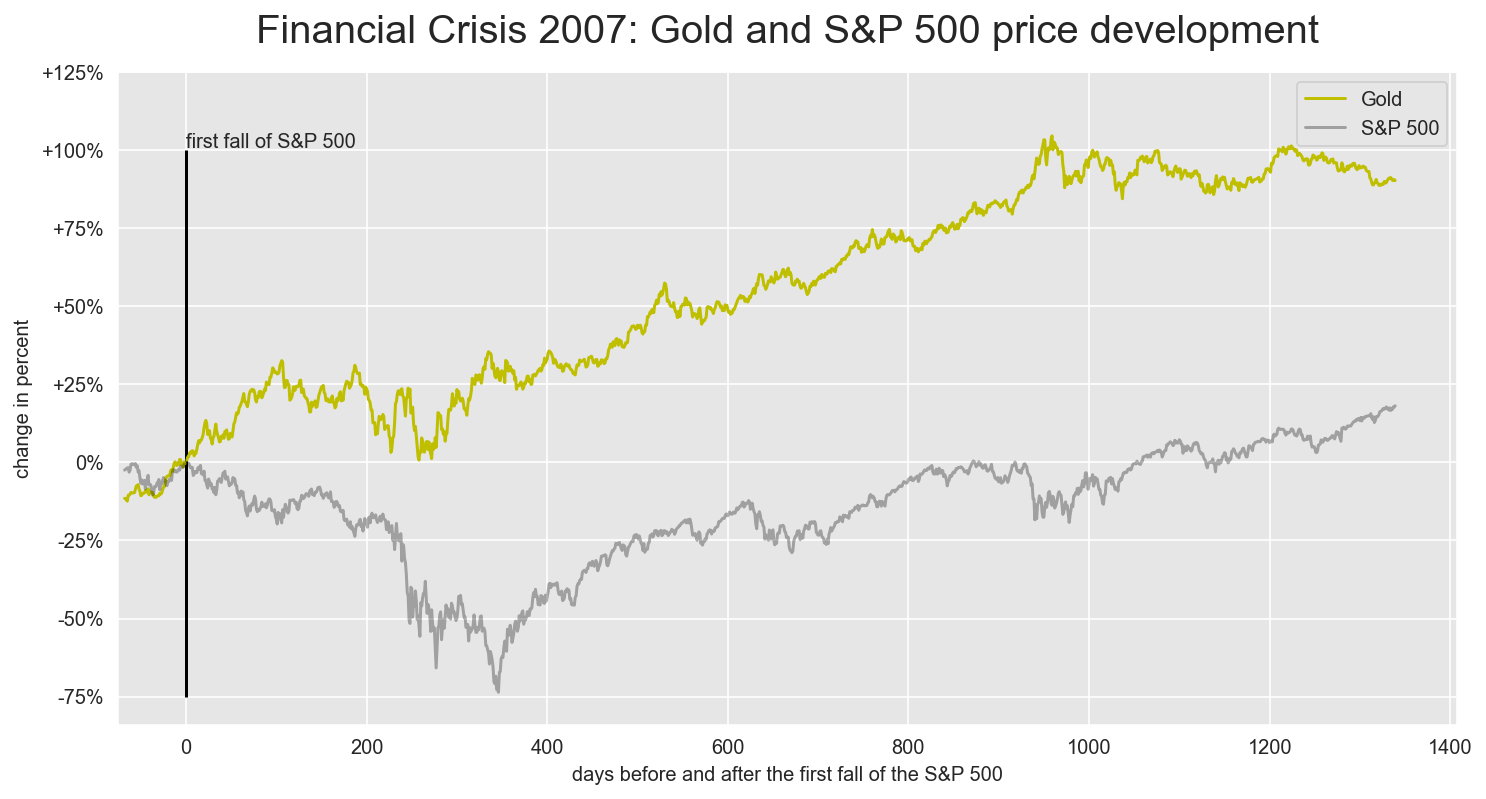

In [65]:
one_on_one_plot(financial_crisis_2007, 'Financial Crisis 2007')

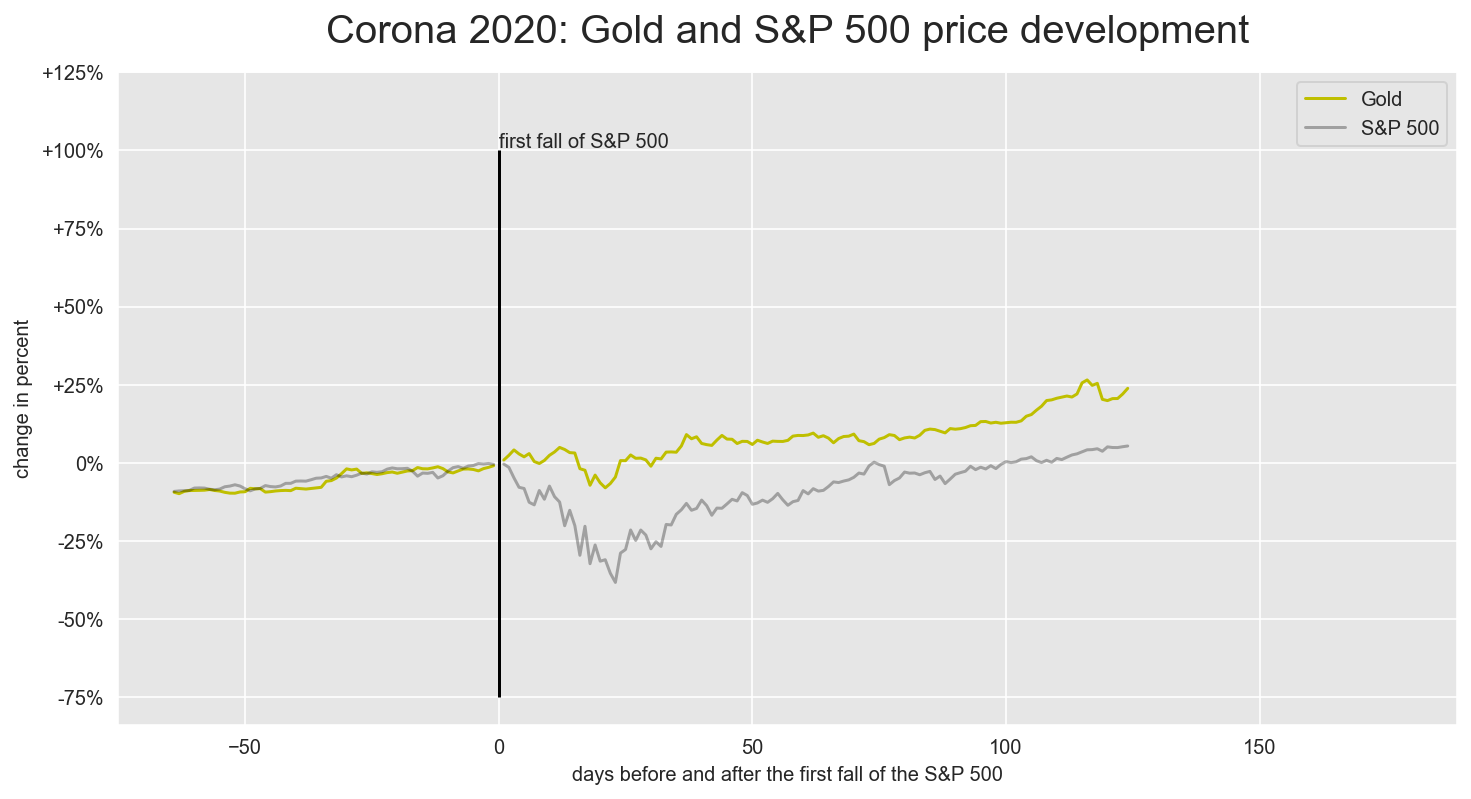

In [66]:
one_on_one_plot(corona_2020, 'Corona 2020')

<a id='max'></a>
### Calculating max percentage gain
to calculate the max percentage gain I need to remove the days before the start of the crisis. For that I can use the code from above, I just changed the name of the variable so that I don't overwrite the existing variables.

In [104]:
#1970s energy crisis
energy_crisis_1970_m = energy_crisis_1970.loc[dates_1970_energy[0]:dates_1970_energy[1]]

# 1973 oil crisis
oil_crisis_1973_m = oil_crisis_1973.loc[dates_1973_oil[0]:dates_1973_oil[1]]

# Early 1980s recession:
early_1980s_recession_m = early_1980s_recession.loc[dates_1980_recession[0]:dates_1980_recession[1]]

# Black Monday:
black_monday_m = black_monday.loc[dates_Black_Monday[0]:dates_Black_Monday[1]]

# Dot-com bubble:
dot_com_bubble_m = dot_com_bubble.loc[dates_Dotcombubble[0]:dates_Dotcombubble[1]]

# Financial crisis of 2007–08:
financial_crisis_2007_m = financial_crisis_2007.loc[dates_Financial_crisis[0]:dates_Financial_crisis[1]]

# Corona (2020):
corona_2020_m = corona_2020.loc[dates_Corona[0]:dates_Corona[1]]

In [105]:
df_final_list = [energy_crisis_1970_m, oil_crisis_1973_m, early_1980s_recession_m, black_monday_m,
                 dot_com_bubble_m, financial_crisis_2007_m, corona_2020_m]
df_final_names = ['energy_crisis_1970', 'oil_crisis_1973', 'early_1980s_recession', 'black_monday', 
                  'dot_com_bubble', 'financial_crisis_2007', 'corona_2020']

In [106]:
for df, df_name in zip(df_final_list, df_final_names):
    print(f'{df_name}: max gain = {df["sum_ptc_change_g"].max()}')

energy_crisis_1970: max gain = 0.22212769140096533
oil_crisis_1973: max gain = 2.8408811614777365
early_1980s_recession: max gain = 0.024606696248487214
black_monday: max gain = 0.09073347289382028
dot_com_bubble: max gain = 0.9975579565928062
financial_crisis_2007: max gain = 1.0463848789003465
corona_2020: max gain = 0.26544226906123236


In [108]:
for df, df_name in zip(df_final_list, df_final_names):
    print(f'{df_name}: min gain = {df["sum_ptc_change_g"].min()}')

energy_crisis_1970: min gain = -0.13301430570389572
oil_crisis_1973: min gain = -0.01743552801069459
early_1980s_recession: min gain = -0.6768550158849499
black_monday: min gain = -0.2298149847929758
dot_com_bubble: min gain = -0.10098624059320227
financial_crisis_2007: min gain = 0.007133152173913082
corona_2020: min gain = -0.07975636017863119


<a id='final'></a>
# Conclusion
To recap the questions of this analysis was: <b>Gold is generally known as the safe haven for investors in such crises and is therefore the profiteer of uncertain times. But is this really the case?</b>
- for the most time Gold price was higher as before, when the S&P reached the same price as before the crisis. Only in two instances gold   performed weaker than the S&P 500 (early 1980s recession, Black Monday)
- The highest gain was after the oil crisis in 1973 with a max gain of 284% based
- The biggest decrease in gold value during a crisis was -68% during the early 1980s recessions 
- In term of length the Corona crisis was the shortest one in history, where the S&P 500 reached a new high only after 181 days, the second smallest was after Black Monday. Here the S&P took 701 days to reach a new high.
- The longest crisis was the oil-crisis in 1973, here the S&P 500 took 2744 days to reach a new high


## Other Visualization Libs

### Plotly

In [25]:
# reset index
energy_crisis_1970.set_index('days_in_crisis', inplace = True)
oil_crisis_1973.set_index('days_in_crisis', inplace = True)
early_1980s_recession.set_index('days_in_crisis', inplace = True)
black_monday.set_index('days_in_crisis', inplace = True)
dot_com_bubble.set_index('days_in_crisis', inplace = True)
financial_crisis_2007.set_index('days_in_crisis', inplace = True)
corona_2020.set_index('days_in_crisis', inplace = True)

In [26]:
# drop unrelevnat columns
oil_crisis_1973 = oil_crisis_1973['sum_ptc_change_g']
energy_crisis_1970 = energy_crisis_1970['sum_ptc_change_g']
early_1980s_recession = early_1980s_recession['sum_ptc_change_g']
black_monday = black_monday['sum_ptc_change_g']
dot_com_bubble = dot_com_bubble['sum_ptc_change_g']
financial_crisis_2007 = financial_crisis_2007['sum_ptc_change_g']
corona_2020 = corona_2020['sum_ptc_change_g']

In [27]:
# concat
gold_crises = pd.concat([energy_crisis_1970, oil_crisis_1973, early_1980s_recession, black_monday, dot_com_bubble, financial_crisis_2007, corona_2020], axis=1)

In [28]:
col_names = ['energy_crisis_1970', 'oil_crisis_1973', 'early_1980s_recession', 'black_monday', 'dot_com_bubble', 
             'financial_crisis_2007', 'corona_2020']

In [29]:
gold_crises.columns = col_names

In [32]:
gold_crises.to_csv('data_plotly_vis.csv')

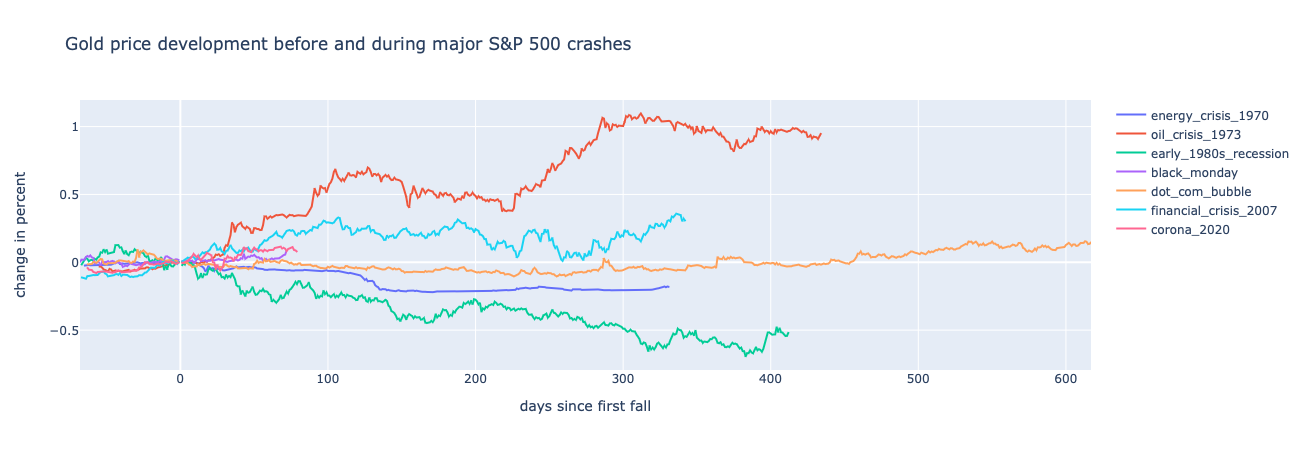

In [35]:
# cretae figure
fig = go.Figure()

# add traces for each crisis
fig.add_trace(go.Scatter(x=gold_crises.index, y=gold_crises.energy_crisis_1970, mode='lines', name='energy_crisis_1970'))
fig.add_trace(go.Scatter(x=gold_crises.index, y=gold_crises.oil_crisis_1973, mode='lines', name='oil_crisis_1973'))
fig.add_trace(go.Scatter(x=gold_crises.index, y=gold_crises.early_1980s_recession, mode='lines', name='early_1980s_recession'))
fig.add_trace(go.Scatter(x=gold_crises.index, y=gold_crises.black_monday, mode='lines', name='black_monday'))
fig.add_trace(go.Scatter(x=gold_crises.index, y=gold_crises.dot_com_bubble, mode='lines', name='dot_com_bubble'))
fig.add_trace(go.Scatter(x=gold_crises.index, y=gold_crises.financial_crisis_2007, mode='lines', name='financial_crisis_2007'))
fig.add_trace(go.Scatter(x=gold_crises.index, y=gold_crises.corona_2020, mode='lines', name='corona_2020'))

# change layout
fig.update_layout(title='Gold price development before and during major S&P 500 crashes',
                   xaxis_title='days since first fall',
                   yaxis_title='change in percent')

# sets hovermode to compare data points
fig.layout.hovermode = 'x'
fig.show()

## Resources
- https://www.quandl.com/data/LBMA-London-Bullion-Market-Association
- https://finance.yahoo.com/quote/%5EGSPC/
- https://stackoverflow.com/questions/35090498/how-to-calculate-percent-change-compared-to-the-beginning-value-using-pandas
- https://stackoverflow.com/questions/151199/how-to-calculate-number-of-days-between-two-given-dates
- https://www.programiz.com/python-programming/nested-dictionary
- https://stackoverflow.com/questions/18648626/for-loop-with-two-variables
- https://unsplash.com/photos/xXq_6_Kwysc